# UNet implementation with complementary tools to try different approaches
Based on https://youtu.be/u1loyDCoGbE for implementation of U-net : https://arxiv.org/pdf/1505.04597.pdf

This notebook is the reference notebook of our implementation, and we will make copies of it, to test different small changes and compare their results.

See cell 6 for general parameters which will change frequently. Otherwise changes will be details here in this cell.

## Specific test details

Here we will try a very long run, with all 160 Session 1 images. And then test on all 197 session 2 images.

We will kickstart the model by loading the state from 500 epoch on the 6 images of session 1 of all different species and living and dead.

In [1]:
# Google Cloud Platform install of dependencies
# %pip install numpy
# %pip install torch
# %pip install glob
# %pip install opencv-python
# %pip install time
# %pip install matplotlib.
# %pip install seaborn

In [2]:
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import glob
import cv2 as cv
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
env = "gcp" # local or colab or gcp
train_or_load = "resume" # train, load or resume : Are we training a model, or just loading a pretrained one ?

In [4]:
#Platfoms specifics
# if env == "colab":
#     from google.colab import drive
#     drive.mount('/content/drive', force_remount=True)
#     !cp "/content/drive/MyDrive/helpers.py" .
#     imgs_names = glob.glob( '/content/drive/MyDrive/th_analysedimages/*.tif')
#     labels_names = glob.glob('/content/drive/MyDrive/labels/*.png')
# elif env == "gcp":
if env == "gcp":
    imgs_names = glob.glob( '/home/jupyter/cs-433-project-2-ml_fools/th_analysedimages/Session1*.tif')
    labels_names = glob.glob('/home/jupyter/cs-433-project-2-ml_fools/th_csv_labels/png_masks_emb/Session1*.png')
    test_imgs_names = glob.glob( '/home/jupyter/cs-433-project-2-ml_fools/th_analysedimages/Session2*.tif')
    test_labels_names = glob.glob('/home/jupyter/cs-433-project-2-ml_fools/th_csv_labels/png_masks_emb/Session2*.png')
    !cp "/home/jupyter/cs-433-project-2-ml_fools/helpers.py" .
#Local github project specifics
# elif env == "local":
#     imgs_names = glob.glob( '/Users/theophanemayaud/Dev/EPFL MA1/Machine Learning/cs-433-project-2-ml_fools/th_analysedimages/*.tif')
#     labels_names = glob.glob('/Users/theophanemayaud/Dev/EPFL MA1/Machine Learning/cs-433-project-2-ml_fools/th_csv_labels/png_masks_emb/*.png')
#     !cp "/Users/theophanemayaud/Dev/EPFL MA1/Machine Learning/cs-433-project-2-ml_fools/helpers.py" .

In [5]:
from helpers import png_to_mask, segment_dataset, compute_emb_surf_pred_error, confusion, out_predict

imgs_names = sorted(imgs_names)
#imgs = [cv.imread(name, cv.IMREAD_UNCHANGED) for name in imgs_names[1]]
print(f"Found {len(imgs_names)} images")

labels_names = sorted(labels_names)
#labels = [png_to_mask(cv.imread(name, cv.IMREAD_UNCHANGED)) for name in labels_names]
print(f"Found {len(labels_names)} labels")

test_imgs_names = sorted(test_imgs_names)
#imgs = [cv.imread(name, cv.IMREAD_UNCHANGED) for name in imgs_names[1]]
print(f"Found {len(test_imgs_names)} test images")

test_labels_names = sorted(test_labels_names)
#labels = [png_to_mask(cv.imread(name, cv.IMREAD_UNCHANGED)) for name in labels_names]
print(f"Found {len(test_labels_names)} test labels")

Found 160 images
Found 160 labels
Found 197 test images
Found 197 test labels


## General parameters are here :

In [6]:
# Training configuration parameters
learning_rate = 1e-4
max_batch_size = 6

num_epochs = 500
# number_of_images = 2
# train_img_pathnames = imgs_names[:number_of_images]
# train_label_pathnames = labels_names[:number_of_images]
train_img_pathnames = imgs_names
train_label_pathnames = labels_names

disp_every_x_epoch = 100
disp_every_x_img = 50
max_seg_to_disp = max_batch_size
disp_every_x_seg = 1

print_images_while_training = True

# Testing predictions parameters
# test_img_start = 300
# test_img_stop = 310
# test_img_pathnames = imgs_names[test_img_start:test_img_stop]
# test_label_pathnames = labels_names[test_img_start:test_img_stop]
test_img_pathnames = test_imgs_names
test_label_pathnames = test_labels_names

print_each_test_stat = False
print_each_test_img = False

# Saving parameters when in train mode
previous_epochs = 501 # useful to track between resumes
save_for_resume = True # takes ~3x more space
model_name = "GCP-batch_500epochAllSession1Img_Adam_CrossEntr_Lr1e-4"
model_description = "Starting from saved model of 500 epochs on 6 session 1 images 3 dead 3 living 3 species each"

UNet picture representation : 

<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" width="300">

In [7]:
# Define the device to train on, if a GPU is available (ex when on Google Colab)
if not torch.cuda.is_available():
    print("Things will go much quicker if you enable a GPU, ex in Colab under 'Runtime / Change Runtime Type'")
else:
    #del model # only needed when re-running multiple times
    torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Selected device is: {device}\n")

Selected device is: cuda



In [8]:
# UNet definitions
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        # functions for going down the U
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.d_double_conv_1 = double_conv(1, 64)
        self.d_double_conv_2 = double_conv(64, 128)
        self.d_double_conv_3 = double_conv(128, 256)
        self.d_double_conv_4 = double_conv(256, 512)
        self.d_double_conv_5 = double_conv(512, 1024)
        
        # functions for going up the U
        self.up_trans_4 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2)        
        self.u_double_conv_4 = double_conv(1024, 512)
        self.up_trans_3 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)
        self.u_double_conv_3 = double_conv(512, 256)
        self.up_trans_2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
        self.u_double_conv_2 = double_conv(256, 128)
        self.up_trans_1 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
        self.u_double_conv_1 = double_conv(128, 64)
        
        self.out = nn.Conv2d(in_channels=64, out_channels=2, kernel_size=1)
        
    def forward(self, image):
        '''makes the 388x388 prediction with the model, image must be 572x572pixels'''
        
        # Going down the U
        d1 = self.d_double_conv_1(image) # first "level"
        # print(x1.size())
        x = self.max_pool_2x2(d1)
        d2 = self.d_double_conv_2(x) # second
        x = self.max_pool_2x2(d2)
        d3 = self.d_double_conv_3(x) # third
        x = self.max_pool_2x2(d3)
        d4 = self.d_double_conv_4(x) # fourth
        x = self.max_pool_2x2(d4)
        x = self.d_double_conv_5(x) # last layer (fifth) : no max pool
        # plt.imshow(x.detach().numpy()[0, 0, :, :])
        
        # Going up the U
        x = self.up_trans_4(x)
        d4 = crop_img(tensor=d4, target_tensor=x) #crop to copy
        x = self.u_double_conv_4(torch.cat([d4, x], 1))
        
        x = self.up_trans_3(x)
        d3 = crop_img(tensor=d3, target_tensor=x)
        x = self.u_double_conv_3(torch.cat([d3, x], 1))
        
        x = self.up_trans_2(x)
        d2 = crop_img(tensor=d2, target_tensor=x)
        x = self.u_double_conv_2(torch.cat([d2, x], 1))
        
        x = self.up_trans_1(x)
        d1 = crop_img(tensor=d1, target_tensor=x)
        x = self.u_double_conv_1(torch.cat([d1, x], 1))
        
        x = self.out(x)
        return x
        
        
    
# some functions so reduce redunduncy
def double_conv(nb_in_channels, nb_out_channels): # Used for every descending step
    conv = nn.Sequential(
        nn.Conv2d(nb_in_channels, nb_out_channels, kernel_size=3),
        nn.ReLU(inplace=True),
        nn.Conv2d(nb_out_channels, nb_out_channels, kernel_size=3),
        nn.ReLU(inplace=True),
    )
    return conv

def crop_img(tensor, target_tensor): # Used for copy and crop between descending and ascending
    target_size = target_tensor.size()[2] # NB they are square so .size[2]=.size[3]
    tensor_size = tensor.size()[2]
    delta = tensor_size - target_size #target is always smaller
    pix_crop = delta // 2
    return tensor[:, :, pix_crop:tensor_size-pix_crop, pix_crop:tensor_size-pix_crop]

In [9]:
# Training function
current_epoch = 0
def train_model(model, img_pathnames, label_pathnames, criterion, optimizer, device, num_epochs=25, 
                disp_every_x_epoch = 1,
                disp_every_x_img = 1,
                max_seg_to_disp = 100, # NB 1 (and not 0) means the first segment is displayed
                disp_every_x_seg = 1,
                previous_epochs = 0):
    points=0 # incrementer for displaying progress
    train_start_time = time.process_time() # For process monitoring

    print("Starting the training on images !")
    model.train()
    epoch_losses = []
    for epoch in range(num_epochs):
        epoch_loss = 0
        for image_i in range(len(img_pathnames)):
            image = cv.imread(img_pathnames[image_i], cv.IMREAD_UNCHANGED)
            label = png_to_mask(cv.imread(label_pathnames[image_i], cv.IMREAD_UNCHANGED))
            
            image_segments, label_segments = segment_dataset([image], [label])
            
            segment_i = 0
            while segment_i < len(image_segments[:, 0, 0]):
                updated_segment_i = segment_i
                since = time.process_time() # For process monitoring
                
#                 img_seg = torch.tensor(image_segments[segment_i, :, :], requires_grad=True, dtype = torch.float, device = device).view(1, 1, 572, 572)
#                 label_seg = torch.tensor(label_segments[segment_i, :, :].astype(float), requires_grad=False, dtype = torch.long, device = device).view(1, 388, 388)
                next_batch_size = max_batch_size
                if next_batch_size > len(image_segments[:, 0, 0])-segment_i:
                    next_batch_size = len(image_segments[:, 0, 0])-segment_i
                img_seg = torch.tensor(image_segments[segment_i:segment_i+next_batch_size, :, :],requires_grad=True, dtype = torch.float, device = device).view(next_batch_size, 1, 572, 572)
                label_seg = torch.tensor(label_segments[segment_i:segment_i+next_batch_size, :, :].astype(float), requires_grad=False, dtype = torch.long, device = device).view(next_batch_size, 388, 388)
                updated_segment_i = segment_i+next_batch_size-1
                
                prediction = model(img_seg)
                
                loss = criterion(prediction, label_seg)
                epoch_loss = epoch_loss + loss.item()
            
                # Compute the gradient
                optimizer.zero_grad()
                                
                loss.backward()
                                
                # Update the parameters of the model with a gradient step
                optimizer.step()
                            
                # Optionnaly display status during training
                if ( epoch%disp_every_x_epoch==0 and image_i%disp_every_x_img==0 
                        and segment_i%disp_every_x_seg==0 and segment_i<max_seg_to_disp ): 
                    if image_i==0 and segment_i==0:
                        print(f"\nEpoch {1+epoch + previous_epochs}/{num_epochs+previous_epochs}", end="")
                    if segment_i==0:
                        print(f"\n|  Image {1+image_i}/{len(img_pathnames)} '{img_pathnames[image_i]}'", end="")
                
                    time_elapsed = time.process_time()-since

                    # Make new prediction so compare before and after step
                    del prediction
                    prediction = model(img_seg)
                    new_loss = criterion(prediction, label_seg)
                    ori_lab_seg = label_seg.cpu().detach().numpy()[0,:,:].astype(int)
                    pred_lab_seg = torch.argmax(prediction, dim=1).cpu().detach().numpy()[0, :, :]

                    emb_surf_pred_error = compute_emb_surf_pred_error(ori_lab_seg, pred_lab_seg, print_values=False)
                    print(f"\n|  |  Segment {1+segment_i}/{len(image_segments[:, 0, 0])} : loss={loss} "+\
                          f"duration={int(time_elapsed)//60}m {int(time_elapsed%60)}s {int(1000*(time_elapsed-int(time_elapsed)))}ms. Loss reduced {loss-new_loss}. "+\
                          f"Emb surf pred err= {np.round(emb_surf_pred_error, 2)}%", end="")
                        
                    # # Also optionally print confusion values :
                    # print(f"\n|  |  Confusion values are :{confusion(ori_lab_seg, pred_lab_seg, data_type='numpy')}")
                    
                    # Also optionnaly print image segment, label and prediction
                    if print_images_while_training == True:
                        _ , axs = plt.subplots(ncols=3, figsize=(40, 40))
                        axs[0].set_title("Segment of original image")
                        axs[0].imshow(img_seg.cpu().detach().numpy()[0,0,:,:])
                        axs[1].set_title("Segment of original label")
                        axs[1].imshow(label_seg.cpu().detach().numpy()[0,:,:])
                        axs[2].set_title("Predicted label segment")
                        axs[2].imshow(torch.argmax(prediction, dim=1).cpu().detach().numpy()[0,:,:])
                        plt.show()
                    
                    points=0

                if ( (epoch%disp_every_x_epoch==0 and image_i%disp_every_x_img==1 and segment_i==0) 
                        or (epoch%disp_every_x_epoch==1 and points==0) ):
                    print("\n   ...Next epochs & images ", end="")
                    points = 1
                else:
                    print(".", end="")
                    points = points+1 
                    if  points>100:
                        print("\n      ...", end="")
                        points = 1
                
                segment_i = updated_segment_i + 1
        epoch_losses.append(epoch_loss)
        current_epoch = 1 + epoch + previous_epochs
    time_elapsed = time.process_time()-train_start_time
    print(f"\n\n Finished training after {int(time_elapsed)//60}m {int(time_elapsed%60)}s")
    plt.plot(range(len(epoch_losses)), epoch_losses)
    plt.title("Losses progression across epochs")
    plt.semilogy()
    plt.show()

In [ ]:
# Actually training the model
if train_or_load == "train" : 
    # Remember here we start from already trained on 6 images 500 epochs
    # Loading the pre-trained model
    PATH = "/content/drive/MyDrive/savedmodels/batch-500epoch6img3specy3dead3livingLr1e-4AdamCrossentrAtEpoch500.pkl"
    if env == "local" or env == "gcp":
        PATH = "./savedmodels/batch-500epoch6img3specy3dead3livingLr1e-4AdamCrossentrAtEpoch500.pkl"
    model = UNet()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    checkpoint = torch.load(PATH)
    print("Model parameters are :")
    print(f"   name : {checkpoint['name']}")
    print(f"   description : {checkpoint['description']}")
    print(f"   Model details dump : {checkpoint['model_details_dump']}")
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.cuda()
#     previous_epochs = checkpoint['epoch']
    model.to(device)
    print("Model successfully loaded !")
        
elif train_or_load == "resume":
    # Loading the pre-trained model
    PATH = "/content/drive/MyDrive/savedmodels/" + model_name + f"AtEpoch{previous_epochs}.pkl"
    if env == "local" or env == "gcp":
        PATH = "./savedmodels/" + model_name + f"AtEpoch{previous_epochs}.pkl"
    model = UNet()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    checkpoint = torch.load(PATH)
    print("Model parameters are :")
    print(f"   name : {checkpoint['name']}")
    print(f"   description : {checkpoint['description']}")
    print(f"   Model details dump : {checkpoint['model_details_dump']}")
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.cuda()
#     previous_epochs = checkpoint['epoch']
    model.to(device)
    print("Model successfully loaded !")
    
if train_or_load == "train" or train_or_load == "resume":
    criterion = torch.nn.CrossEntropyLoss()
    train_model(model, train_img_pathnames, train_label_pathnames, criterion, optimizer, device, num_epochs,
                disp_every_x_epoch,
                disp_every_x_img,
                max_seg_to_disp,
                disp_every_x_seg,
                previous_epochs)

In [11]:
# Loading the pre-trained model
if train_or_load == "load":  
    PATH = "/content/drive/MyDrive/savedmodels/" + model_name + f"AtEpoch{previous_epochs}.pkl"
    if env == "local" or env == "gcp":
        PATH = "./savedmodels/" + model_name + f"AtEpoch{previous_epochs}.pkl"

    if device == "cuda":
        map_to_device = "cuda:0"
    else:
        map_to_device = "cpu"

    model = UNet()

    checkpoint = torch.load(PATH)

    print("Model parameters are :")
    print(f"   name : {checkpoint['name']}")
    print(f"   description : {checkpoint['description']}")
    print(f"   Model details dump : {checkpoint['model_details_dump']}")
    model.load_state_dict(checkpoint['model_state_dict'])
#     # If wanting to resume training :
#     optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    model.to(device)
    print("Model successfully loaded !")

Current epoch is : 0
Starting testing predictions 

.....................................................................................................................................................................................................Image looks like :
/home/jupyter/cs-433-project-2-ml_fools/th_analysedimages/Session2_living_6-qp-18_795.tif
/home/jupyter/cs-433-project-2-ml_fools/th_csv_labels/png_masks_emb/Session2_living_6-qp-18_795_mask_emb.png


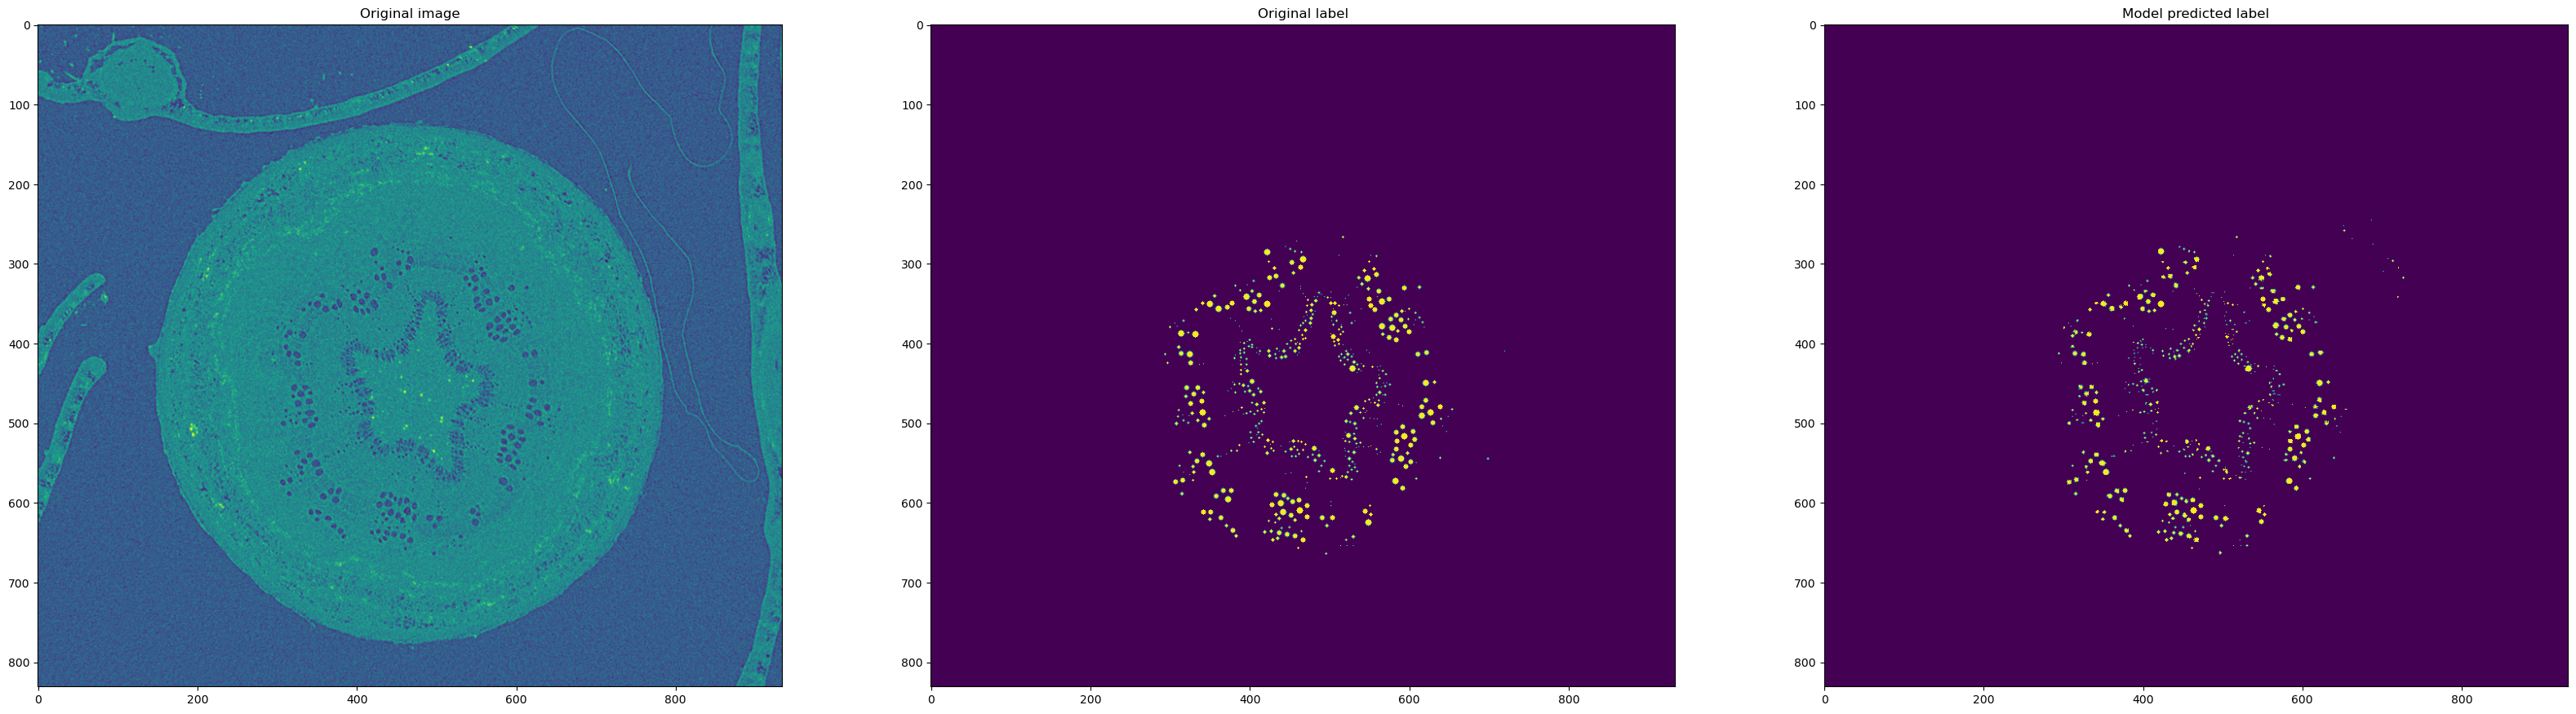

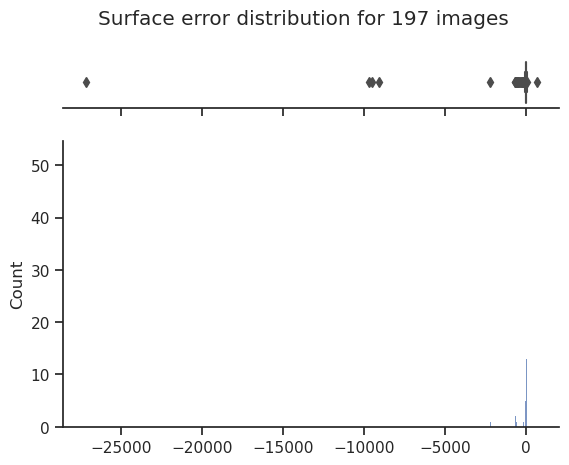

Finished testing with mean surface error=-352.67748503308076%


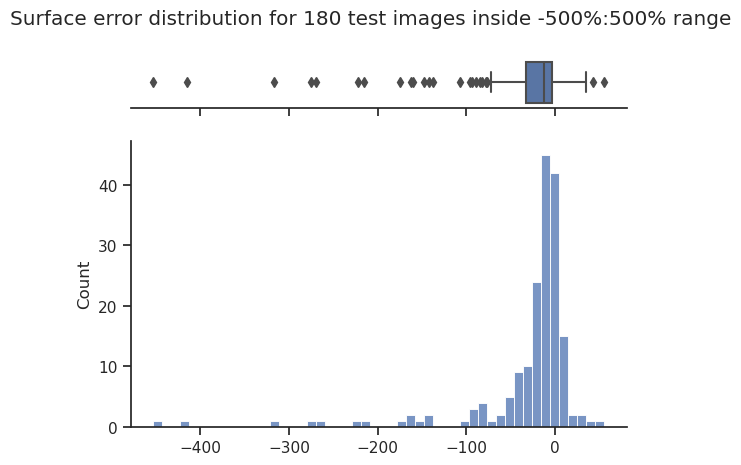

Finished testing with mean surface error notwhithstanding extremes=-31.239647302111774%


Check of performance on training set :
Starting testing predictions 

................................................................................................................................................................Image looks like :
/home/jupyter/cs-433-project-2-ml_fools/th_analysedimages/Session1_living_6-qp-12_766.tif
/home/jupyter/cs-433-project-2-ml_fools/th_csv_labels/png_masks_emb/Session1_living_6-qp-12_766_mask_emb.png


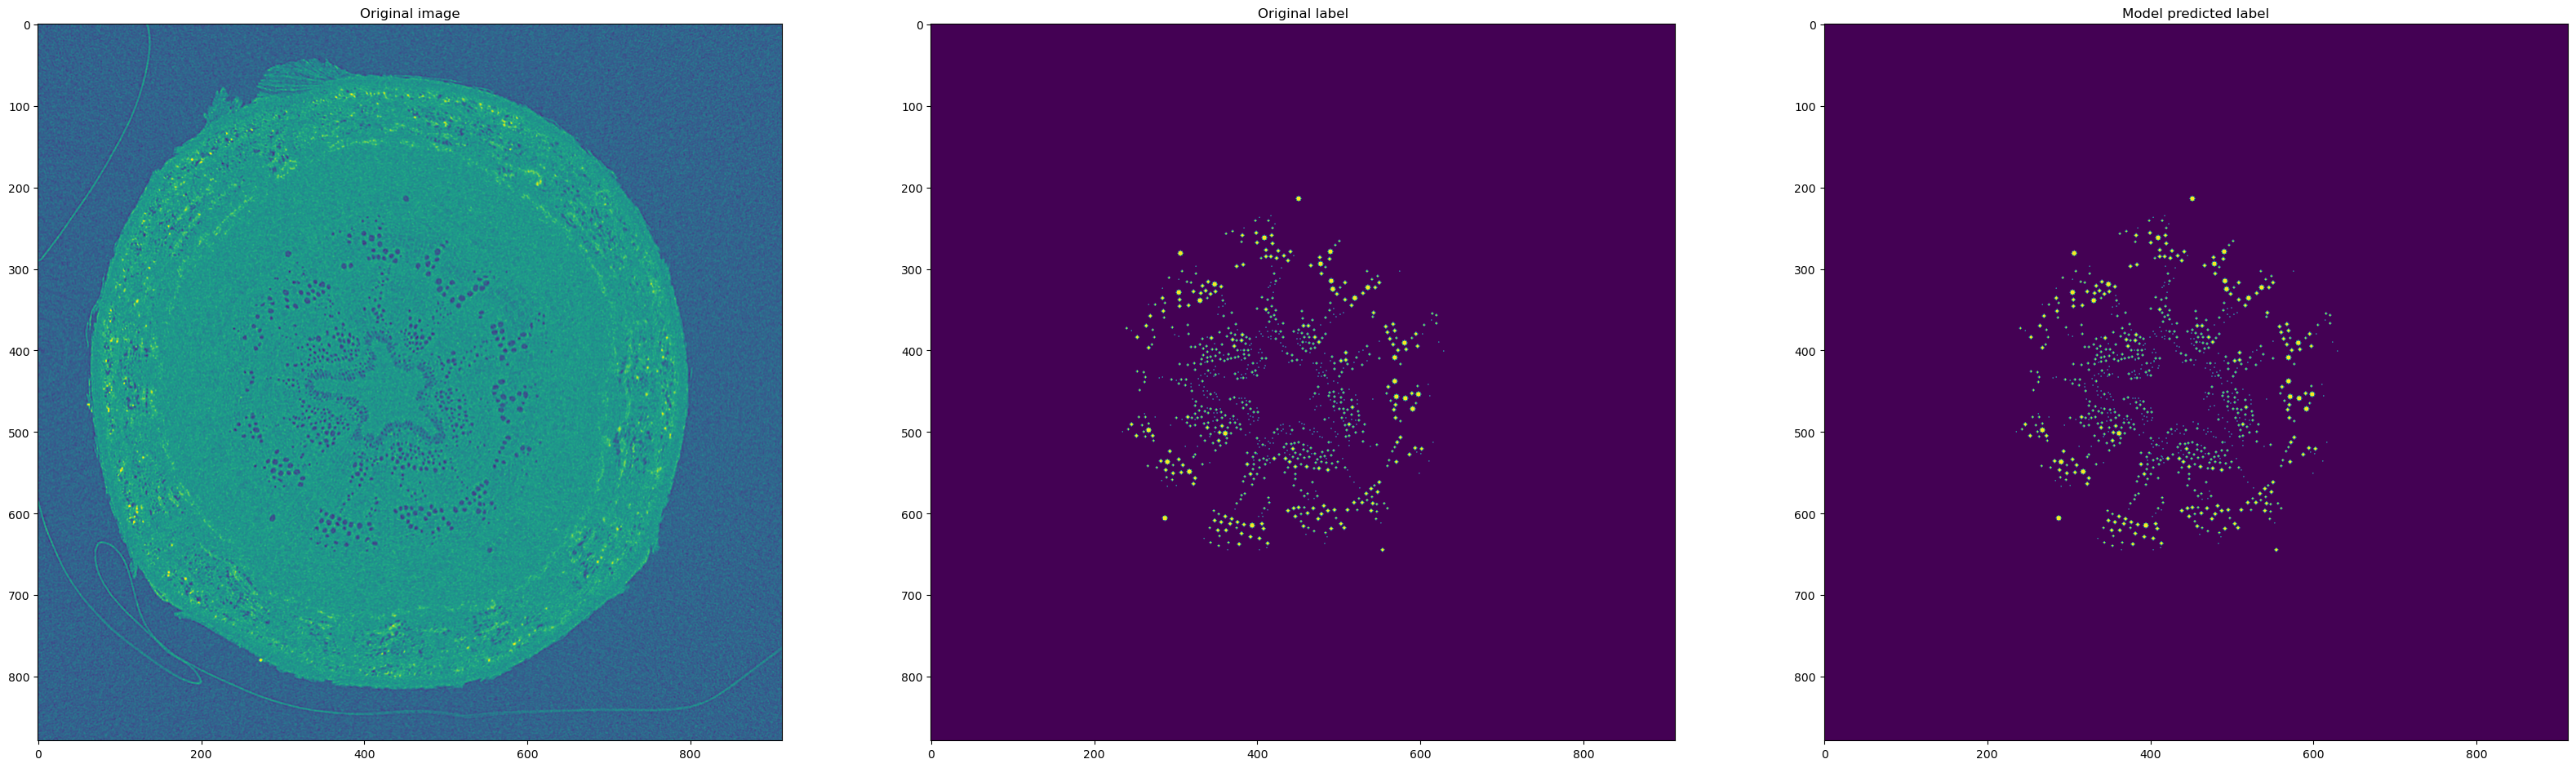

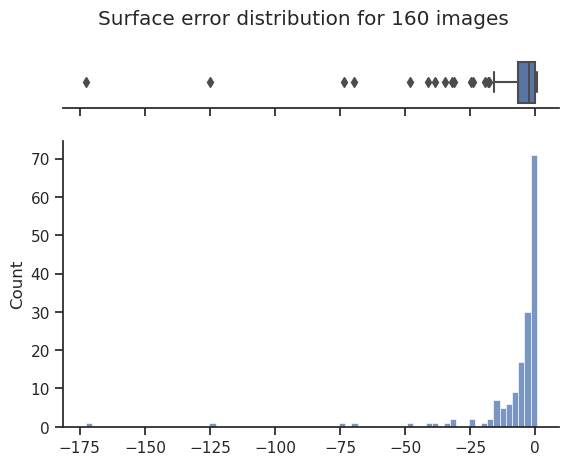

Finished testing with mean surface error=-8.029179488018078%


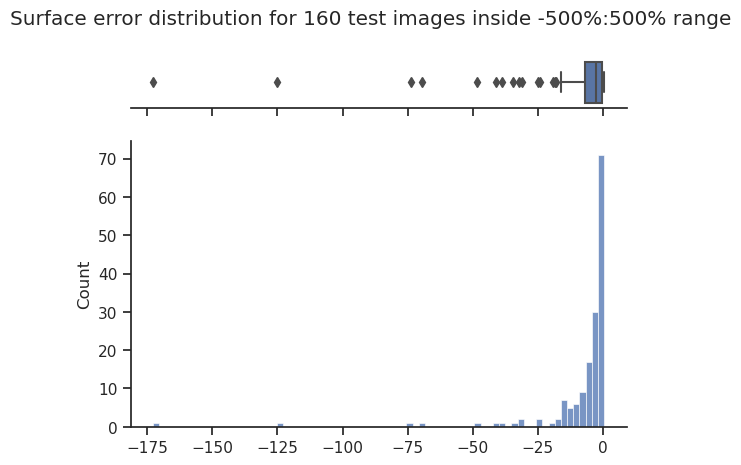

Finished testing with mean surface error notwhithstanding extremes=-8.029179488018078%


In [19]:
# Test predictions
print(f"Current epoch is : {current_epoch}")
def test_predictions(model, test_img_pathnames, test_label_pathnames):
    emb_surf_pred_errors_list = []

    print("Starting testing predictions \n")

    for img_i in range(len(test_img_pathnames)):
        test_img = cv.imread(test_img_pathnames[img_i], cv.IMREAD_UNCHANGED)
        test_label = png_to_mask(cv.imread(test_label_pathnames[img_i], cv.IMREAD_UNCHANGED))

        pred_label = out_predict(model, test_img, device)

        emb_surf_pred_error = compute_emb_surf_pred_error(test_label, pred_label, print_values=False)
        if print_each_test_stat == True:
            print(f"Emb surf pred err={emb_surf_pred_error}%")
            print(f"Confusion values are :{confusion(pred_label, test_label, data_type='numpy')}")
        else:
            print(".", end="")
        emb_surf_pred_errors_list.append(emb_surf_pred_error)

        if img_i == len(test_img_pathnames)-1 or print_each_test_img == True:
            print("Image looks like :")
            print(test_img_pathnames[img_i])
            print(test_label_pathnames[img_i])
            _ , axs = plt.subplots(ncols=3, figsize=(40, 40))

            axs[0].set_title("Original image")
            axs[0].imshow(test_img)

            axs[1].set_title("Original label")
            axs[1].imshow(test_label)

            axs[2].set_title("Model predicted label")
            axs[2].imshow(pred_label)
            plt.show()
            print("\n")

    # Draw histogram with boxplot of surface error values
    sns.set(style="ticks")
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                        gridspec_kw={"height_ratios": (.15, .85)})
    f.suptitle(f"Surface error distribution for {len(test_img_pathnames)} images")
    sns.boxplot(x=emb_surf_pred_errors_list, ax=ax_box)
    sns.histplot(x=emb_surf_pred_errors_list, ax=ax_hist)
    ax_box.set(yticks=[])
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    plt.show()
    plt.style.use('default')

    print(f"Finished testing with mean surface error={np.mean(emb_surf_pred_errors_list)}%")
    
    data = np.array(emb_surf_pred_errors_list)
    emb_surf_pred_errors_list_no_outliers = data[abs(data.astype(int))<500]
    
    # Draw histogram with boxplot of surface error values
    sns.set(style="ticks")
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                        gridspec_kw={"height_ratios": (.15, .85)})
    f.suptitle(f"Surface error distribution for {len(emb_surf_pred_errors_list_no_outliers)} test images inside -500%:500% range")
    sns.boxplot(x=emb_surf_pred_errors_list_no_outliers, ax=ax_box)
    sns.histplot(x=emb_surf_pred_errors_list_no_outliers, ax=ax_hist)
    ax_box.set(yticks=[])
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    plt.show()
    plt.style.use('default')

    print(f"Finished testing with mean surface error notwhithstanding extremes={np.mean(emb_surf_pred_errors_list_no_outliers)}%")


    
test_predictions(model, test_img_pathnames, test_label_pathnames)

print("\n\nCheck of performance on training set :")
test_predictions(model, train_img_pathnames, train_label_pathnames)

In [13]:
# Saving the model
if train_or_load == "train" or train_or_load == "resume":
    print(f"Remember to set a model name that makes it easy to identify")
    print(f"Here are the notebook parameters : \ncriterion={criterion} \noptimizer={optimizer} \nlr={learning_rate}, \nepochs={num_epochs}, \nPrevEpoch={previous_epochs}")
    
    PATH = "/content/drive/MyDrive/savedmodels/" + model_name + f"AtEpoch{num_epochs+previous_epochs}.pkl"
    if env == "local" or env == "gcp":
        PATH = "./savedmodels/" + model_name + f"AtEpoch{num_epochs+previous_epochs}.pkl"

    print("\nmodel_name = " + model_name)
    print("model_description = " + model_description)
    print("PATH = " + PATH)
    # Warning : only save once name and descriptions are set correctly
    if save_for_resume == True:
        torch.save({
                'name': model_name,
                'epoch': num_epochs + previous_epochs,
                'description': model_description,
                'model_details_dump': f"env={env}, train_or_load={train_or_load}, learning rate={learning_rate}, epochs={num_epochs}, PrevEpoch={previous_epochs}, optimizer={optimizer}, criterion={criterion}",         
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(), # Only needed when planning to resume training from loaded model
                }, PATH)
    else:
        torch.save({
                'name': model_name,
                'epoch': num_epochs + previous_epochs,
                'description': model_description,
                'model_details_dump': f"env={env}, train_or_load={train_or_load}, learning rate={learning_rate}, epochs={num_epochs}, PrevEpoch={previous_epochs}, optimizer={optimizer}, criterion={criterion}",         
                'model_state_dict': model.state_dict(),
                }, PATH)
    print("Model saved !")

Remember to set a model name that makes it easy to identify
Here are the notebook parameters : 
criterion=CrossEntropyLoss() 
optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
) 
lr=0.0001, 
epochs=500, 
PrevEpoch=1

model_name = GCP-batch_500epochAllSession1Img_Adam_CrossEntr_Lr1e-4
model_description = Starting from saved model of 500 epochs on 6 session 1 images 3 dead 3 living 3 species each
PATH = ./savedmodels/GCP-batch_500epochAllSession1Img_Adam_CrossEntr_Lr1e-4AtEpoch501.pkl
Model saved !
